# **Classifying buildings Post Hurricane using Satellite Imagery**

Hurricane Iota was a devastating late-season Category 4 Atlantic hurricane which caused severe damage to areas of Central America already devastated by Hurricane Eta just less than two weeks prior. The 31st and final tropical cyclone, 30th named storm, 14th hurricane, and record-tying seventh major hurricane of the record-breaking 2020 Atlantic hurricane season, Iota originated as a tropical wave that moved into the Eastern Caribbean on November 10. Over the next few days, the wave began to become better organized and by November 13, it developed into a tropical depression north of Colombia.
</br>
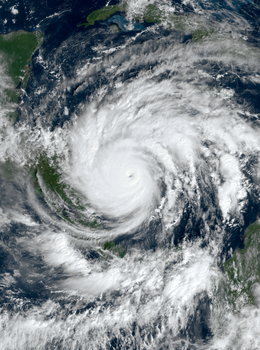
</br>
Iota's precursor disturbance generated flash flooding on several Caribbean islands. Tropical cyclone watches and warnings were first issued on November 14 in parts of Colombia, Nicaragua, and Honduras, with the latter two countries still recovering from Eta. Heavy rains associated with a tropical wave and Iota brought heavy rainfall to parts of Colombia, leading to flash flooding and mudslides. Extremely heavy rain fell on much of Nicaragua, widening flash flooding caused by the hurricane's high storm surge. Mudslides caused extensive damage and multiple deaths. At least 67 people were killed due to Iota, including at least 28 in Nicaragua and 16 in Honduras, among other countries.

## Problem Statement

With the dataset collected from satelitte imaging, we are trying to identify whether a House has been damaged or not damaged by visualising the top of the houses from the satellite image.
Since doing the damage survey manually by driving by each house is both time and cost expensive, we are trying to build a model which will be able to do so by just looking at the image data collected by the satelitte imagery.
</br>
The dataset is divided into 4 categories:
1. train_another: the training data; 5000 images of each class(damage/no damage)
2. validation_another: the validation data; 1000 images of each class(damage/no damage)
3. test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes
4. test: the balanced test data; 1000 images of each class(damage/no damage)
</br>
</br>
The dataset provided below has been labelled into two categories:
* No damage
</br>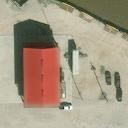
</br>
* Damage - 
</br>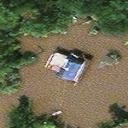
</br>

## *Methodologies used in the modelling blocks*

> Reading the datasets in Google Colab Environment by using data generator from keras.

> Preprocessing of Images such as rescaling and orientation/normalization.

> Making our custom CNN model with regularization and noting downn the performance measures.

> Transfer Learning Approach:- Using a Pretrained Model - MobileV2 Net and noting down its performance and accuracies.

> Visualiznig saliency maps for feature importance for the model with better performacne. 

> Comparing the performances of Pre trained and custom model

> Reporting loss and accuracy measures via appropriate plots.

## Importing the Required Libraries 

In [ ]:
!pip install tf_keras_vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import pandas as pd 
import cv2

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve

import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input, Dropout, BatchNormalization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import cm 

%matplotlib inline
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from PIL import Image
from numpy import asarray
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import keras.backend as K
from keras.preprocessing import image


In [ ]:
##Changing the directory for working 
!pwd
import os
os.chdir('/content/drive/MyDrive/Univ.AI/Project_AI2')
!pwd

## Reading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Following creates a directory, downloads the file and unzips it. 

if os.path.isdir('/content/gdrive/MyDrive/Post-hurricane12'):
    print('Found dataset' )
else:
    os.makedirs('gdrive/My Drive/Post-hurricane12')

    !gdown 1zVPVrsEBmkiHnl1eZFCVZ0pxfu7XZ4Ah
    !unzip Post-hurricane.zip  -d gdrive/My\ Drive/Post-hurricane12/

Found dataset


In [ ]:
## Directory fixing 

train_dir = '/content/gdrive/MyDrive/Post-hurricane12/train_another'
val_dir = '/content/gdrive/MyDrive/Post-hurricane12/validation_another'
test_dir_bal = '/content/gdrive/MyDrive/Post-hurricane12/test'
test_dir_imbal = '/content/gdrive/MyDrive/Post-hurricane12/test_another'

In [ ]:
classes  = ['damage', 'no_damage']
train_img_path = [os.listdir(train_dir + '/' + cls) for cls in classes]
val_img_path = [os.listdir(val_dir + '/' + cls) for cls in classes]
test_img_path_bal = [os.listdir(test_dir_bal + '/' + cls) for cls in classes]
test_img_path_imbal = [os.listdir(test_dir_imbal + '/' + cls) for cls in classes]

In [ ]:
df = pd.DataFrame({'Train':[len(train_img_path[0]), len(train_img_path[1])], 
                   'Validation':[len(val_img_path[0]), len(val_img_path[1])],
                   'Test':[len(test_img_path_bal[0]), len(test_img_path_bal[1])],
                   'Test Imbalanced':[len(test_img_path_imbal[0]), len(test_img_path_imbal[1])]})
# df.columns = []
df.index = [classes]
df

,Train,Validation,Test,Test Imbalanced
damage,5000,1000,1000,8000
no_damage,5000,1000,1000,1000


### Preprocessing

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [ ]:
#initialising ImageDataGenerator instances for Train, test and validation datasets
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
#loading the instances defined above to the datasets by specifying path
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle = True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle = True
)

test_data = test_datagen.flow_from_directory(
    test_dir_bal,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle = True
)

test_data_imbalanced = test_datagen.flow_from_directory(
    test_dir_imbal,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle = True
)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


### Defining functions for Visualisation like Feature Maps, CAM, Saliency and Grad-CAM

Class Attribution Maps

In [ ]:
#defining a function for feature mapping of the model
def feature_maps(model, layer_id, input_image):
    
    model_ = tf.keras.Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_(input_image)[0]

In [ ]:
def required_layer(model, layer_name):
  layer_dict = dict([(layer.name, layer) for layer in model.layers])
  layer = layer_dict[layer_name]
  return layer



def activation_map(model, image_path, layer_name, label):
  x_new = np.expand_dims(image_path, axis=0)
  image_class = np.argmax(label)

  #getting the output layer and predictions in the model
  class_weights = model.layers[-1].get_weights()[0]
  final_conv_layer = required_layer(model, layer_name)
  get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
  [conv_outputs, predictions] = get_output([x_new])
  conv_outputs = conv_outputs[0, :, :, :]

  #getting the plot part of the model
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

  for index, weight in enumerate(class_weights[:, image_class]):
    cam += weight * conv_outputs[:, :, index]
             
  cam /= np.max(cam)
  cam = cv2.resize(cam, (224, 224))
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_HSV)
  heatmap[np.where(cam < 0.2)] = 0
        
  img = heatmap * 0.5 + image_path       
  scaled_image = (((img - img.min()) * 255) / (img.max() - img.min())).astype(np.uint8)

  #plotting the images      
  fig, ax = plt.subplots(1, 3, figsize=(10, 10))
  ax[0].imshow(image_path)
  ax[0].set_title('Original image')
  ax[0].axis('off')

  ax[1].imshow(img)
  ax[1].set_title(f'CAM of image for {layer_name}')
  ax[1].axis('off')

  ax[2].imshow(heatmap)
  ax[2].set_title('outline of heatmap')
  ax[2].axis('off')


SALIENCY MAPS

In [ ]:
def Saliency_map_plotting(model, image, label):

  replace2linear = ReplaceToLinear()
  saliency = Saliency(model, model_modifier = replace2linear)

  f, ax = plt.subplots(len(image), 2, figsize=(10, 8))
  for i in range(len(image)):
      # Actual image
      ax[i][0].set_title(f'Image{i}', fontsize=16)
      ax[i][0].imshow(image[i], cmap='jet')
      ax[i][0].axis('off')
  
      # Gradcam of the image
      score = BinaryScore(labels[i])
      saliency_map = saliency(score, img_taken[i], smooth_samples=20)
      saliency_map = normalize(saliency_map)

      ax[i][1].set_title(f'Saliency map for Image {i}', fontsize=16)
      ax[i][1].imshow(saliency_map[0], cmap='inferno')
      ax[i][1].axis('off')


GRAD-CAM

In [ ]:
# Defining the plotting function for Grad-CAMs for the chosen images.

def gradcam_plot(model, images, score_labels, labels):

  grad = Gradcam(model, clone=True)

  f, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(18, 8))
  for i in range(len(images)):
    # Actual image
    pred_img = np.round(model.predict(np.expand_dims(images[i], axis=0)))
    ax[i][0].set_title(f'Actual : {classes[int(labels[i])]} \n Predicted : {classes[int(pred_img[0][0])]}', fontsize=16)
    ax[i][0].imshow(images[i], cmap='jet')
    ax[i][0].axis('off')
    
    # Gradcam of the image
    score = BinaryScore(score_labels[i])
    grad_cam = grad(score, images[i], penultimate_layer=-4)
    grad_cam = normalize(grad_cam)

    heatmap = np.uint8(cm.jet(grad_cam[0])[..., :3] * 255)
    ax[i][1].set_title('GradCam', fontsize=16)
    ax[i][1].imshow(images[i])
    ax[i][1].imshow(heatmap, cmap='jet', alpha=0.4) # overlay
    ax[i][1].axis('off')

  plt.tight_layout()
  plt.show()

## Customised CNN Model 

We are creating a Customised CNN model with a model architecture as shown below:
</br>
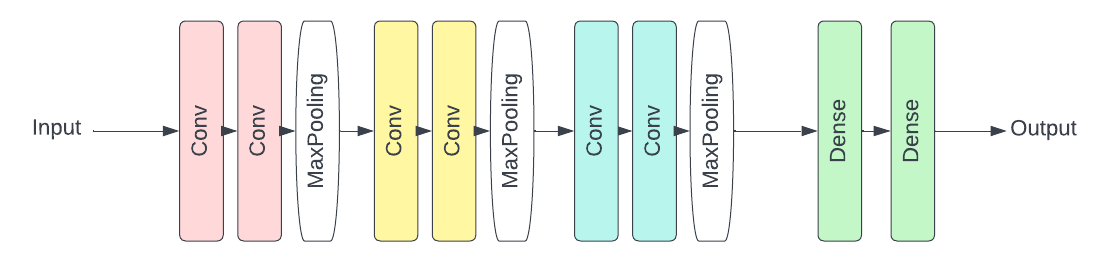


In [ ]:
model_cnn = Sequential()

#adding convolution layer
model_cnn.add(Conv2D(32, (2,2), strides = 1, padding='same', activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model_cnn.add(Conv2D(32, (2,2), strides = 1, padding='same', activation='relu'))
model_cnn.add(MaxPool2D((2,2)))

model_cnn.add(Conv2D(64, (3,3), strides = 1, activation='relu'))
model_cnn.add(Conv2D(64, (3,3), strides = 1, activation='relu'))
model_cnn.add(MaxPool2D((2,2)))

model_cnn.add(Conv2D(128, (3,3), strides = 1, activation='relu'))
model_cnn.add(Conv2D(256, (3,3), strides = 1, activation='relu'))
model_cnn.add(MaxPool2D((2,2)))

#adding fully connected layer
model_cnn.add(Flatten())
model_cnn.add(Dense(512,activation='relu'))
model_cnn.add(Dense(256,activation='relu'))
#adding output layer
model_cnn.add(Dense(1, activation='sigmoid'))



#compiling the model
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
#fitting the model_cnn

history_1 = model_cnn.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            #restore_best_weights=True
        )
    ]
)

In [ ]:
# Saving the history file of the trained CNN model.

# np.save('history_cnn.npy', history_1.history)

In [ ]:
# Use below code to load the history file. Ensure correct file path.

#history_1=np.load('history_cnn.npy',allow_pickle='TRUE').item()

In [ ]:
# Saving the weights to a file.

# model_cnn.save_weights('/content/drive/MyDrive/Univ.AI/Project_AI2/CNN_1.h5')

In [ ]:
# For directly loading the saved weights.

model_cnn.load_weights('/content/gdrive/MyDrive/Post-hurricane12/CNN_1.h5')

In [ ]:
# Evaluating on the test Data set.

model_cnn.evaluate(test_data)

63/63 [==============================] - 5s 82ms/step - loss: 0.2929 - accuracy: 0.8815


[0.2928526699542999, 0.8815000057220459]

In [ ]:
# Higher accuracy but need to look at precision and recall.

model_cnn.evaluate(test_data_imbalanced)

282/282 [==============================] - 23s 82ms/step - loss: 0.1518 - accuracy: 0.9468


[0.15178215503692627, 0.9467777609825134]

Interpretation
</br>


In [ ]:
# Loading the history of the customized cnn model
hist = np.load('/content/drive/MyDrive/Project-AI2/history_cnn.npy', allow_pickle = True).item()

In [ ]:
# Plotting the accuracy and loss for the customized cnn model for both train and validation data
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(np.linspace(0, 5, 5), hist['accuracy'], label = 'Train Accuracy')
ax[0].plot(np.linspace(0, 5, 5), hist['val_accuracy'], label = 'Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_label('accuracy')

ax[1].plot(np.linspace(0, 5, 5), hist['loss'], label = 'Train Loss')
ax[1].plot(np.linspace(0, 5, 5), hist['val_loss'], label = 'Validation Loss')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_label('loss')

In [ ]:
# Getting the True labels from the test data.

true_label = np.array([])

for i in range(len(test_data)):

    y = test_data[i][1]
    true_label = np.concatenate((true_label, y))

In [ ]:
# Getting the True labels from the Imbalanced test data.

true_imb_label = np.array([])

for i in range(len(test_data_imbalanced)):

    y = test_data_imbalanced[i][1]
    true_imb_label = np.concatenate((true_imb_label, y))

In [ ]:
# Making predictions on the test data to get prediction labels.

preds  = model_cnn.predict(test_data)
pred_label = [0 if preds[i]<=0.5 else 1 for i in range(len(preds))]

In [ ]:
# Making predictions on the Imbalanced test data to get prediction labels.

preds_imb  = model_cnn.predict(test_data_imbalanced)
pred_imb_label = [0 if preds_imb[i]<=0.5 else 1 for i in range(len(preds_imb))]

In [ ]:
# Creating the confusion matrix for balanced test data.

cm = confusion_matrix(true_label, pred_label)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.title("Confusion Matrix for Balanced Test set", size=20)
plt.show()

In [ ]:
pres_test = tf.keras.metrics.Precision()
pres_test.update_state(true_label, pred_label)

pres_test_imb = tf.keras.metrics.Precision()
pres_test_imb.update_state(true_imb_label, pred_imb_label)

print(f"Precision on Test Set : {pres_test.result().numpy():.4f}")
print(f"Precision on Imbalanced Test Set : {pres_test_imb.result().numpy():.4f}")

In [ ]:
rec_test_imb = tf.keras.metrics.Recall()
rec_test_imb.update_state(true_imb_label, pred_imb_label)
print(f"Recall on Imbalanced Test Set : {rec_test_imb.result().numpy():.4f}")

In [ ]:
f1_imb = 2*(rec_test_imb.result().numpy())*(pres_test_imb.result().numpy())/(pres_test_imb.result().numpy()+rec_test_imb.result().numpy())
print(f"F1 score for Imbalanced Test set : {f1_imb:.4f}")

In [ ]:
# For customized cnn model with test data

print(classification_report(true_label, pred_label))

In [ ]:
# For customized cnn Model with imbalanced test data

print(classification_report(true_imb_label, pred_imb_label))

## Transfer Learning  -  Pretained Model (MobileV2 Net)

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

In [ ]:
#inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = mobilenet.output

dense = tf.keras.layers.Dense(1024, activation='relu')(x)

dense_2 = tf.keras.layers.Dense(512, activation='relu')(dense)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)


model = tf.keras.Model(mobilenet.input, outputs)


print(model.summary())

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
time_start = time.time()
EPOCHS = 5



history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
time_end = time.time()
print('Total time taken: {}'.format(time_end - time_start)) #16.6407607079

Epoch 1/5
313/313 [==============================] - 130s 406ms/step - loss: 0.2809 - accuracy: 0.8804 - auc: 0.9524 - val_loss: 0.4418 - val_accuracy: 0.8315 - val_auc: 0.9419
Epoch 2/5
313/313 [==============================] - 127s 407ms/step - loss: 0.1818 - accuracy: 0.9234 - auc: 0.9797 - val_loss: 0.2884 - val_accuracy: 0.8925 - val_auc: 0.9628
Epoch 3/5
313/313 [==============================] - 126s 403ms/step - loss: 0.1601 - accuracy: 0.9321 - auc: 0.9840 - val_loss: 0.3517 - val_accuracy: 0.8490 - val_auc: 0.9650
Epoch 4/5
313/313 [==============================] - 127s 406ms/step - loss: 0.1479 - accuracy: 0.9408 - auc: 0.9865 - val_loss: 0.2279 - val_accuracy: 0.9110 - val_auc: 0.9721
Epoch 5/5
313/313 [==============================] - 126s 404ms/step - loss: 0.1309 - accuracy: 0.9472 - auc: 0.9893 - val_loss: 0.2025 - val_accuracy: 0.9220 - val_auc: 0.9793
Total time taken: 637.8553869724274


In [ ]:
# Saving the history file of the trained CNN model.

np.save('history_transfer_cnn.npy', history.history)

In [ ]:
# Use below code to load the history file. Ensure correct drive file path from the folder provided.

#history_2=np.load('history_transfer_cnn.npy',allow_pickle='TRUE').item()

In [ ]:
# Saving the weights to a file.

model.save_weights('/content/gdrive/MyDrive/Post-hurricane12/Transfer_CNN.h5')

In [ ]:
# For directly loading the saved weights.

model.load_weights('/content/gdrive/MyDrive/Post-hurricane12/Transfer_CNN.h5')

In [ ]:
# Evaluating the model on test set.

model_score = model.evaluate(test_data)
print(f"The Accuracy of the Model : {model_score[1]*100:.2f} %")

63/63 [==============================] - 7s 87ms/step - loss: 0.1824 - accuracy: 0.9305 - auc: 0.9844
The Accuracy of the Model : 93.05 %


In [ ]:
# Evaluating the model on imbalanced test set.

model_score_imbal = model.evaluate(test_data_imbalanced)
print(f"The Accuracy of the Model : {model_score_imbal[1]*100:.2f} %")

282/282 [==============================] - 27s 96ms/step - loss: 0.1321 - accuracy: 0.9414 - auc: 0.9768
The Accuracy of the Model : 94.14 %


In [ ]:
# Getting the True labels from the test data.

true_label = np.array([])

for i in range(len(test_data)):

    y = test_data[i][1]
    true_label = np.concatenate((true_label, y))

In [ ]:
# Getting the True labels from the Imbalanced test data.

true_imb_label = np.array([])

for i in range(len(test_data_imbalanced)):

    y = test_data_imbalanced[i][1]
    true_imb_label = np.concatenate((true_imb_label, y))

In [ ]:
# Making predictions on the test data to get prediction labels.

preds  = model.predict(test_data)
pred_label = [0 if preds[i]<=0.5 else 1 for i in range(len(preds))]

In [ ]:
# Making predictions on the Imbalanced test data to get prediction labels.

preds_imb  = model.predict(test_data_imbalanced)
pred_imb_label = [0 if preds_imb[i]<=0.5 else 1 for i in range(len(preds_imb))]

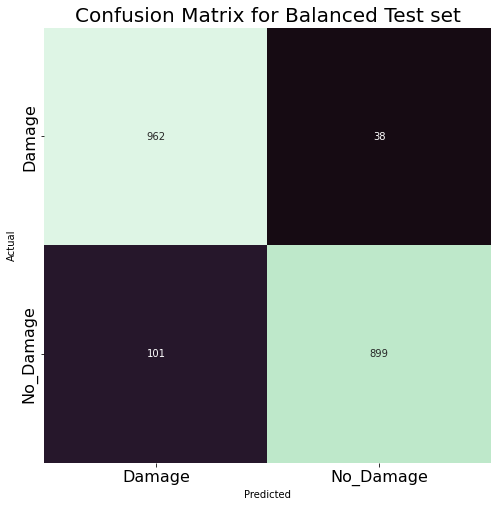

In [ ]:
# Creating the confusion matrix for balanced test data.

cm = confusion_matrix(true_label, pred_label)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.title("Confusion Matrix for Balanced Test set", size=20)
plt.show()

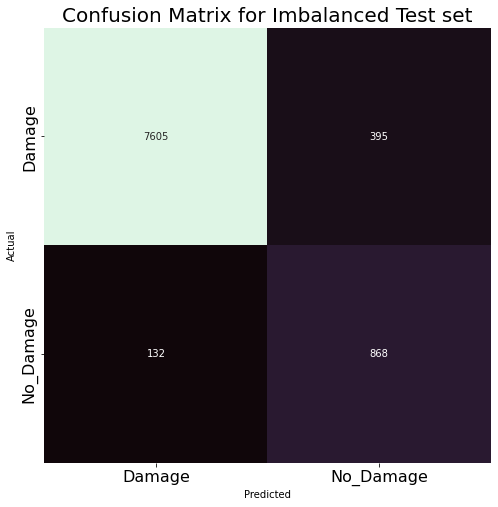

In [ ]:
# Creating the confusion matrix for Imbalanced test data.

cm_imb = confusion_matrix(true_imb_label, pred_imb_label)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_imb, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Damage', 'No_Damage'], fontsize=16)
plt.title("Confusion Matrix for Imbalanced Test set", size=20)
plt.show()

## Comparison of Pre-trained Model and customised model



* Precision

* Recall  

* F1 Scores 

* ROC curves 









In [ ]:
pres_test = tf.keras.metrics.Precision()
pres_test.update_state(true_label, pred_label)

pres_test_imb = tf.keras.metrics.Precision()
pres_test_imb.update_state(true_imb_label, pred_imb_label)

print(f"Precision on Test Set : {pres_test.result().numpy():.4f}")
print(f"Precision on Imbalanced Test Set : {pres_test_imb.result().numpy():.4f}")

Precision on Test Set : 0.9594
Precision on Imbalanced Test Set : 0.6873


In [ ]:
rec_test_imb = tf.keras.metrics.Recall()
rec_test_imb.update_state(true_imb_label, pred_imb_label)
print(f"Recall on Imbalanced Test Set : {rec_test_imb.result().numpy():.4f}")

Recall on Imbalanced Test Set : 0.8680


In [ ]:
f1_imb = 2*(rec_test_imb.result().numpy())*(pres_test_imb.result().numpy())/(pres_test_imb.result().numpy()+rec_test_imb.result().numpy())
print(f"F1 score for Imbalanced Test set : {f1_imb:.4f}")

F1 score for Imbalanced Test set : 0.7671


In [ ]:
# For pre-trained Model

print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      1000
         1.0       0.96      0.90      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
# For pre-trained Model

print(classification_report(true_imb_label, pred_imb_label))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      8000
         1.0       0.69      0.87      0.77      1000

    accuracy                           0.94      9000
   macro avg       0.84      0.91      0.87      9000
weighted avg       0.95      0.94      0.94      9000



Interpretation

In [ ]:
# Incomplete Code for ROC curve. 

fpr_test, tpr_test, thresh_test  = roc_curve(true_label, model.predict(test_data).ravel())
fpr_imb, tpr_imb, thresh_imb = roc_curve(true_imb_label, model.predict(test_data_imbalanced).ravel())

## Visualizing Saliency Maps for Customised model

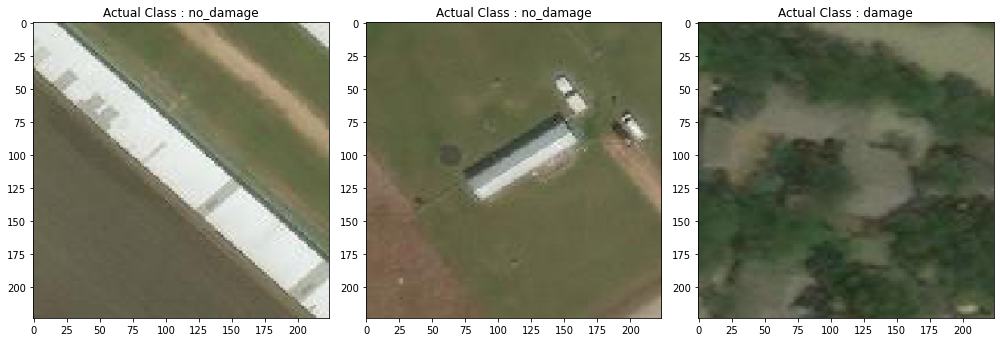

In [ ]:
#plotting the images from Test data
for X, y in test_data:

    img_taken = X[0:3]
    labels = y[0:3]
    break

fig, ax = plt.subplots(1,3, figsize=(14,6))

for i in range(3):

    ax[i].imshow(img_taken[i])
    ax[i].set_title(f"Actual Class : {classes[int(labels[i])]}")  

plt.tight_layout()  

 Interpretation

## Visualising for SoTA model

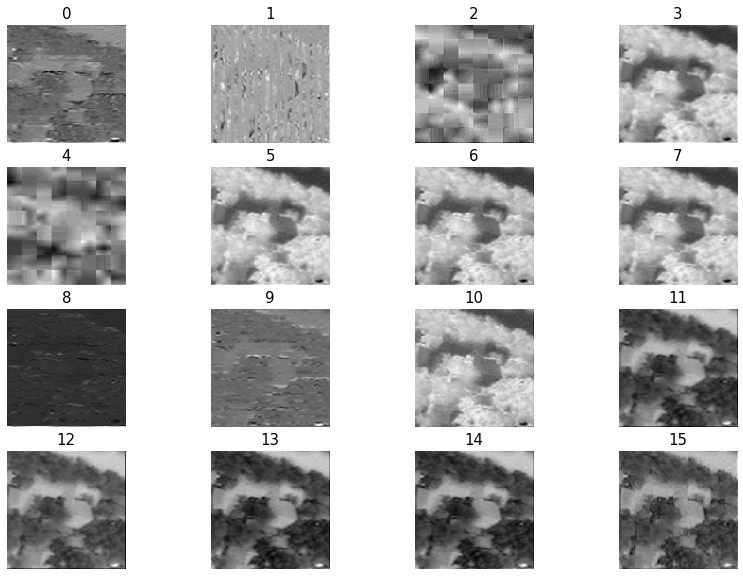

In [ ]:
#using the defined feature_maps function on the test data plotted above
maps = feature_maps(model, 1, np.expand_dims(img_taken[2], axis=0))
img_maps = maps[:,:,0:16]

fig, ax = plt.subplots(4,4,figsize=(14,10))

for i in range(4):
    for j in range(4):

        ax[i][j].imshow(img_maps[:,:,(4*i)+j], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title((4*i)+j, size=15)

### Visualising the methods defined in the functions above

CAM


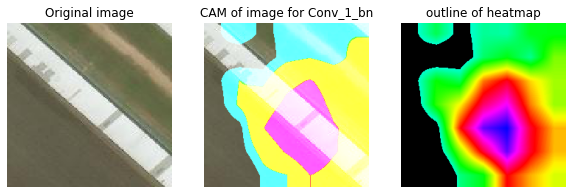

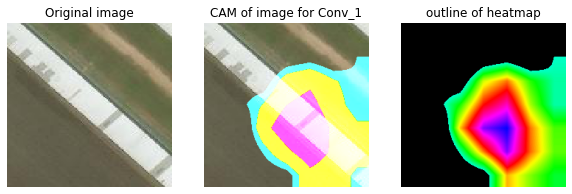

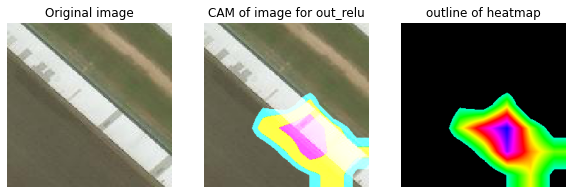

In [ ]:
layers = ['Conv_1_bn','Conv_1','out_relu']
for layer in layers:
  activation_map(model, image_path = X[0], layer_name = layer, label = y[0])

Saliency

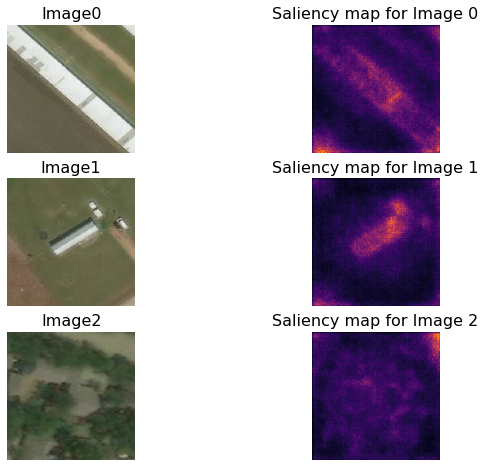

In [ ]:
Saliency_map_plotting(model,img_taken, labels)

Grad-CAM

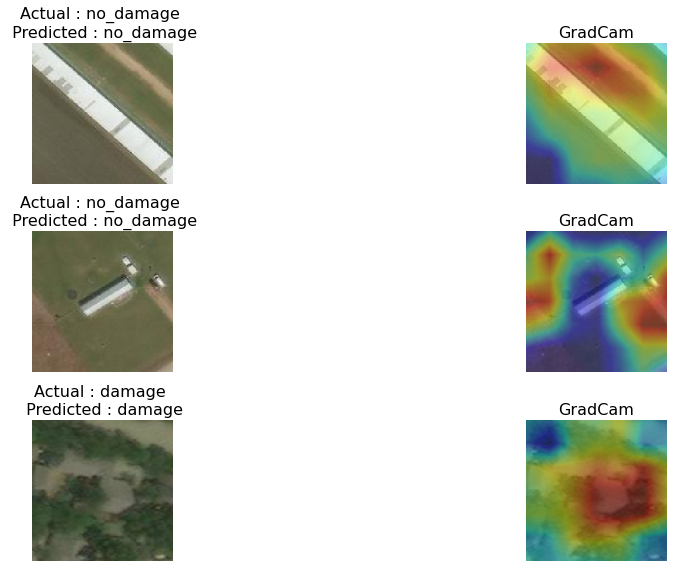

In [ ]:
# Displaying grad-cam for the selected images.
gradcam_plot(model, img_taken, labels, labels)

In [ ]:
#Getting the misclassified images and their labels.

misclassify = []
labels = []
mis_labels = []

for X, y in test_data:

    preds = model.predict(X)
    pred_correct = [1 if preds[i]>0.5 else 0 for i in range(len(preds))]    
    break

for i in range(len(preds)):
    if pred_correct[i]!= y[i]:
        misclassify.append(X[i])
        labels.append(y[i])
        mis_labels.append(pred_correct[i])


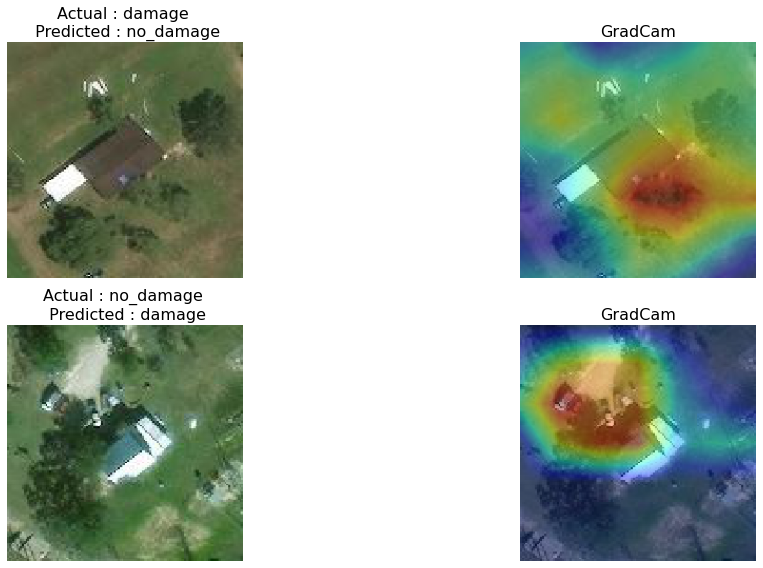

In [ ]:
# Showing Grad-CAMs for misclassified images only.

gradcam_plot(model, misclassify, mis_labels, labels)

## Inferences 

## References 


> **Keras functions and handling**:
https://www.tensorflow.org/api_docs/python/tf/keras


> For the visualisation of the Class attribution map, we have taken reference from
https://github.com/jacobgil/keras-cam/blob/master/cam.py

> **MobileV2 Net Transfer Learning Approach**:
https://colab.research.google.com/drive/1eyBBEbMSHn16DTrlkpmunztSRW64UKih?usp=sharing (My University Course Project on Pneumonia Images Classification using chest x-rays)











